출처: https://hu-nie.tistory.com/entry/DICOM%EC%9D%98-%EB%AA%A8%EB%93%A0-%EA%B2%83-1

를 보고 DICOM에 대한 정리와 캐글 코드를 보고 작성한 노트북

## DICOM 이란? 
DICOM(Digital Imaging and Communications in Medicine): 의료 영상에서 정보를 처리, 저장, 인쇄 및 전송하기 위한 표준, 해당 데이터는 파일 형식 정의와 네트워크 통신 프로토콜이 포함

- DICOM파일은 DICOM형식으로 이미지와 환자 데이터를 수신할 수 있는 두 엔티티간에 교환할 수 있음
- DICOM 표준을 따르는 파일의 확장자는 .dcm을 사용


## DICOM File Format
DICOM의 파일 구조는 크게 두가지 영역으로 구성된다. (File Meta Information + Object Instance or Informamtion Object)

아래는 DICOM의 파일 구조
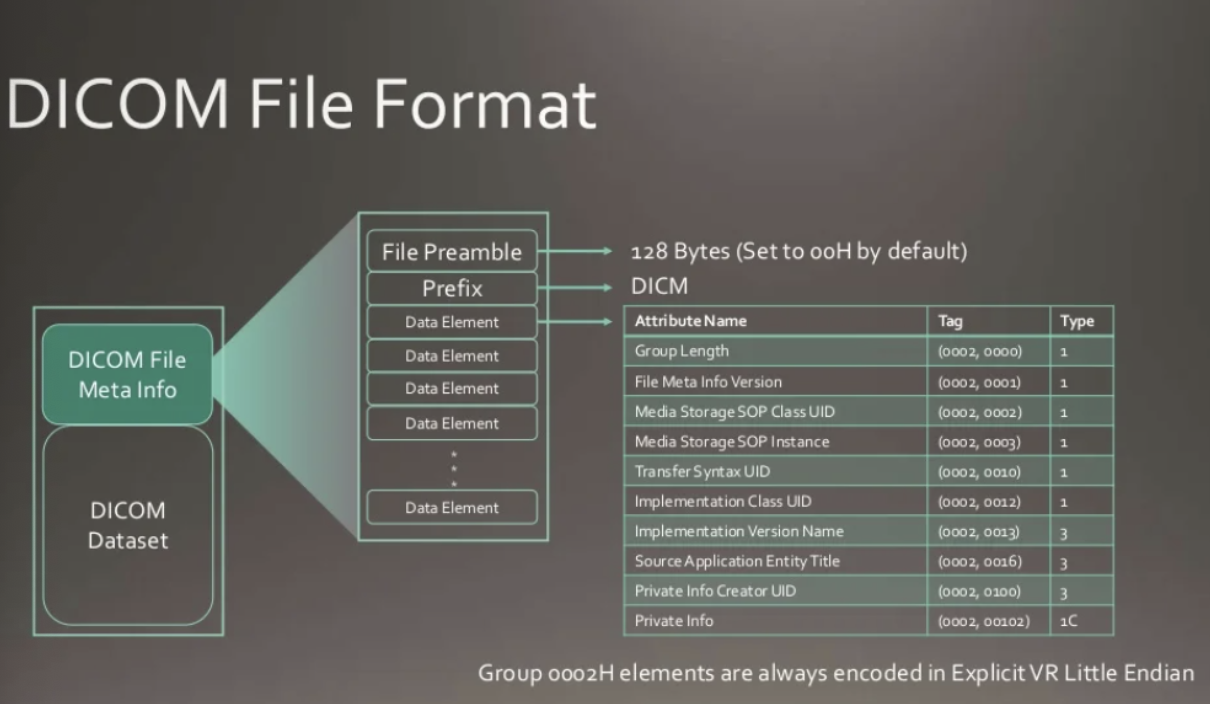 

A. File Meta Information
- File Preamble: 128byte로 구성된 더미 바이트로 주요 구성은 0 값으로 구성되어 있지만, 필요시 특별한 정보를 담을 수 있음.
- DICOM Prefix: DICOM의 정체성을 나타내는 영역. Preamble 이후에  4byte는 "D","I","C","M"을 뜻하는 Char(4)가 와야함.
- File Meta Elements: DICOM파일 형식의 파일 메타 정보 형식을 지원하는데 필요항 파일 메타 요소를 지정
- Information object: 이미지/영상 데이터

아래는 File meta Elements
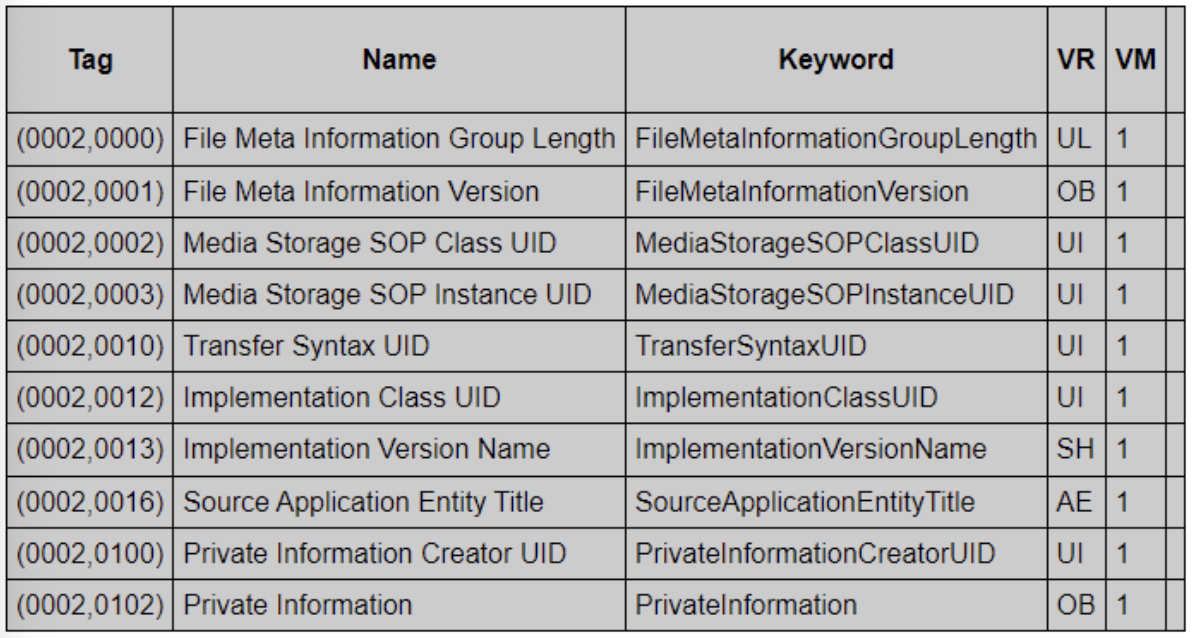

B. Information Object

Information Object는 Data Element로 구성되어 있음. 또한, Data Set은 IOD(Information Object Definition)형식을 따르는데 IOD는 Entity-relationship model을 중심으로 아래의 그림과 같이 information entities, modules, attributes로 구성되어 있음.

다음은 IOD형식을 따르는 구조애 대한 전반적인 설명을 나타내는 그림.
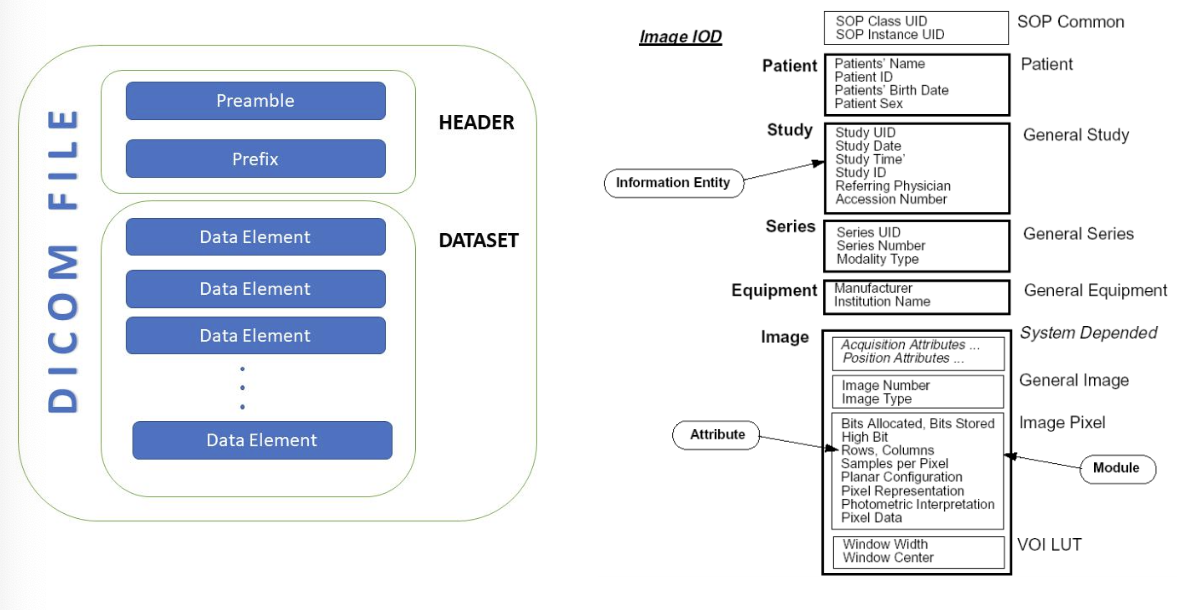

추가적으로 IOD는 정보교환을 위한 정보의 내용과 형식을 표준화하는데 사용되며 구조적으로 IOD는 IE(Information Entity) -> Module -> attributes 들로 구성

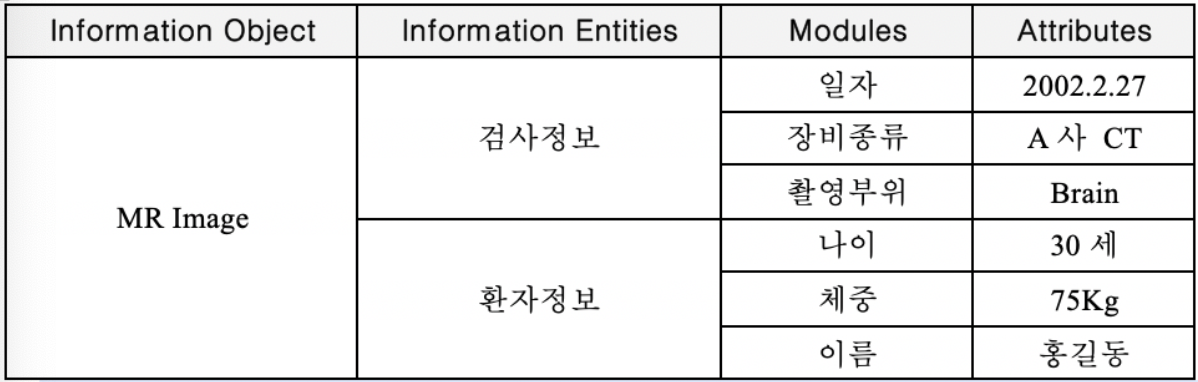

cf) MR 영상을 위한 MR IOD는 환자정보 IE, 검사정보 IE, 시리즈정보 IE, 영상정보 IE 등으로 구성되어 있고, 영상정보 IE는 다시 영사의 일반적인 내용을 다루는 모듈과 MR 영상의 특수한 특성에 대해 다루는 모듈로 구성되어 있고, 각각의 모듈에는 개별적인 세부 속성들이 정의되어있음.

예를들어, MRI(=MR Image)라는 것을 하나의 객체(Information Object)라고 설정하고, 해당 객체를 여러 entity를 이용해 표현한다. 환자정보를 나타내는 entity, 검사정보를 나타내는 entity, 이미지정보를 다나태는 entity 등이 있음.

DICOM 파일 구조는 환자 분들의 개인 신상정보(ex 나이, 성별 등), 수행한 검사 정보(MR인지 CT인지 등), 영상의 정보에 대해 규정하기 위해 필요한 다양한 속성들이 존재한다. 이는 attribute라고 부르며 수천개가 존재.

다음은 attribute를 구성하는 요소
- Attribute Name: 속성에 대한 이름
- Tag: 시스템이 해당 속상을 식별하는 용도로 사용하는 4byte의 값
- Type: 속성 입력의 필수/선택 여부 관련 정보
- Attribute description: 해당 속성에 대한 상세한 설명

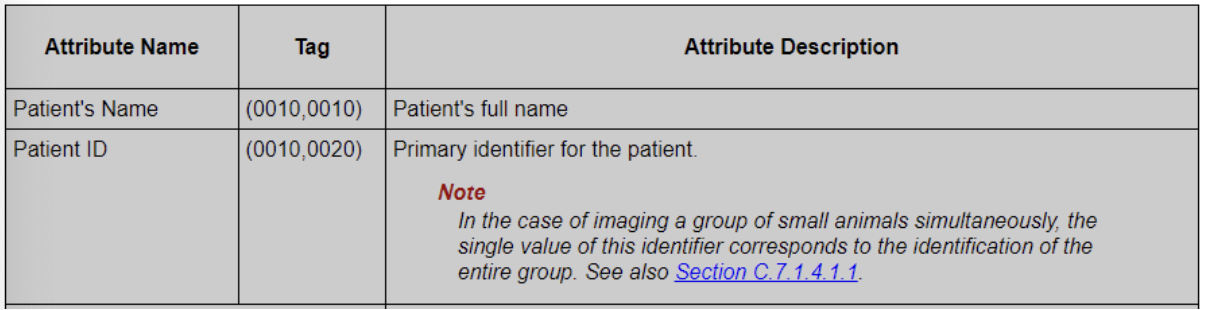

위 그림은 attribute를 설명하기 위한 그림이라면 아래는 DICOM에 실질적으로 저장된 형태를 나타냄.

attribute는 Tag와 VR(Value Representation)과 Value Length, Value Field(실질적인 값)으로 구성된다.

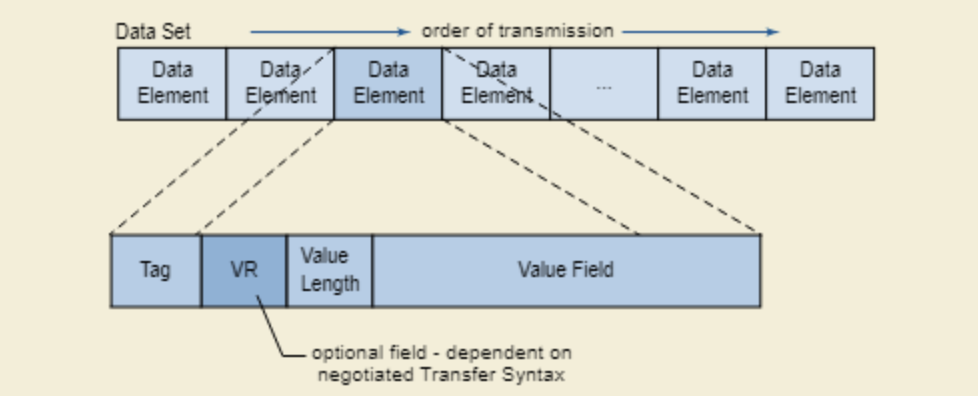

DICOM에서 실제 Image데이터는 Image entity -> Image Pixel moudle -> PixelData attribute로 접근하면된다.

## Visualize CT DICOM Data

### Load package

In [44]:
IS_LOCAL = True
import numpy as np
import pandas as pd
from skimage.io import imread
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
if(IS_LOCAL):
    import pydicom as dicom
else:
    import dicom
import os
%matplotlib inline

In [7]:
PATH = "./siim-medical-image"
print(os.listdir(PATH))

['dicom_dir', 'full_archive.npz', 'overview.csv', 'tiff_images']


### Read overview data

In [10]:
data_df = pd.read_csv(os.path.join(PATH, "overview.csv"))
data_df.head()

Unnamed: 0  Age  Contrast ContrastTag  \
0           0   60      True        NONE   
1           1   69      True        NONE   
2           2   74      True     APPLIED   
3           3   75      True        NONE   
4           4   56      True        NONE   

                                      raw_input_path  id  \
0   ../data/50_50_dicom_cases\Contrast\00001 (1).dcm   0   
1  ../data/50_50_dicom_cases\Contrast\00001 (10).dcm   1   
2  ../data/50_50_dicom_cases\Contrast\00001 (11).dcm   2   
3  ../data/50_50_dicom_cases\Contrast\00001 (12).dcm   3   
4  ../data/50_50_dicom_cases\Contrast\00001 (13).dcm   4   

                            tiff_name                          dicom_name  
0  ID_0000_AGE_0060_CONTRAST_1_CT.tif  ID_0000_AGE_0060_CONTRAST_1_CT.dcm  
1  ID_0001_AGE_0069_CONTRAST_1_CT.tif  ID_0001_AGE_0069_CONTRAST_1_CT.dcm  
2  ID_0002_AGE_0074_CONTRAST_1_CT.tif  ID_0002_AGE_0074_CONTRAST_1_CT.dcm  
3  ID_0003_AGE_0075_CONTRAST_1_CT.tif  ID_0003_AGE_0075_CONTRAST_1_CT.dcm  
4  ID_0004_AGE_0056_CONTRAST_1_CT.tif  ID_0004_AGE_0056_CONTRAST_1_CT.dcm

In [11]:
print("CT Medical images - rows:", data_df.shape[0], " columns:", data_df.shape[1])

CT Medical images - rows: 100  columns: 8


### Read TIFF data
TIFF는 "Tagged Image File Format"의 약자로, 이미지를 저장하는 데 사용되는 파일 형식

JPEG파일보다 훨씬 더 많은 이미지 데이터를 저장(고품질)

In [23]:
print("Number of TIFF images:", len(os.listdir(os.path.join(PATH, "tiff_images"))))

Number of TIFF images: 100


In [25]:
tiff_data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+"/tiff_images/*.tif")])
tiff_data.head()

path
0  ./siim-medical-image/tiff_images\ID_0000_AGE_0...
1  ./siim-medical-image/tiff_images\ID_0001_AGE_0...
2  ./siim-medical-image/tiff_images\ID_0002_AGE_0...
3  ./siim-medical-image/tiff_images\ID_0003_AGE_0...
4  ./siim-medical-image/tiff_images\ID_0004_AGE_0...

In [18]:
def process_data(path):
    data = pd.DataFrame([{'path': filepath} for filepath in glob(PATH+path)])
    data['file'] = data['path'].map(os.path.basename)
    data['ID'] = data['file'].map(lambda x: str(x.split('_')[1]))
    data['Age'] = data['file'].map(lambda x: int(x.split('_')[3]))
    data['Contrast'] = data['file'].map(lambda x: bool(int(x.split('_')[5])))
    data['Modality'] = data['file'].map(lambda x: str(x.split('_')[6].split('.')[-2]))
    return data

In [27]:
tiff_data = process_data('/tiff_images/*.tif')
tiff_data.head()

path  \
0  ./siim-medical-image/tiff_images\ID_0000_AGE_0...   
1  ./siim-medical-image/tiff_images\ID_0001_AGE_0...   
2  ./siim-medical-image/tiff_images\ID_0002_AGE_0...   
3  ./siim-medical-image/tiff_images\ID_0003_AGE_0...   
4  ./siim-medical-image/tiff_images\ID_0004_AGE_0...   

                                 file    ID  Age  Contrast Modality  
0  ID_0000_AGE_0060_CONTRAST_1_CT.tif  0000   60      True       CT  
1  ID_0001_AGE_0069_CONTRAST_1_CT.tif  0001   69      True       CT  
2  ID_0002_AGE_0074_CONTRAST_1_CT.tif  0002   74      True       CT  
3  ID_0003_AGE_0075_CONTRAST_1_CT.tif  0003   75      True       CT  
4  ID_0004_AGE_0056_CONTRAST_1_CT.tif  0004   56      True       CT

### Read DICOM data

In [28]:
print("Number of DICOM files:", len(os.listdir(PATH + "/dicom_dir")))

Number of DICOM files: 100


In [30]:
dicom_data = process_data('/dicom_dir/*.dcm')
dicom_data.head()

path  \
0  ./siim-medical-image/dicom_dir\ID_0000_AGE_006...   
1  ./siim-medical-image/dicom_dir\ID_0001_AGE_006...   
2  ./siim-medical-image/dicom_dir\ID_0002_AGE_007...   
3  ./siim-medical-image/dicom_dir\ID_0003_AGE_007...   
4  ./siim-medical-image/dicom_dir\ID_0004_AGE_005...   

                                 file    ID  Age  Contrast Modality  
0  ID_0000_AGE_0060_CONTRAST_1_CT.dcm  0000   60      True       CT  
1  ID_0001_AGE_0069_CONTRAST_1_CT.dcm  0001   69      True       CT  
2  ID_0002_AGE_0074_CONTRAST_1_CT.dcm  0002   74      True       CT  
3  ID_0003_AGE_0075_CONTRAST_1_CT.dcm  0003   75      True       CT  
4  ID_0004_AGE_0056_CONTRAST_1_CT.dcm  0004   56      True       CT

### Data Exploration

overview.csv의 내용이 tiff_images 폴더의 데이터와 일치하는지 확인

In [53]:
def countplot_comparison(feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 4))
    s1 = sns.countplot(x = data_df[feature], ax = ax1)
    s1.set_title("Overview data")    
    s2 = sns.countplot(x = tiff_data[feature], ax = ax2)
    s2.set_title("Tiff files data")
    s3 = sns.countplot(x = dicom_data[feature], ax = ax3)
    s3.set_title("Dicom files data")
    plt.show()

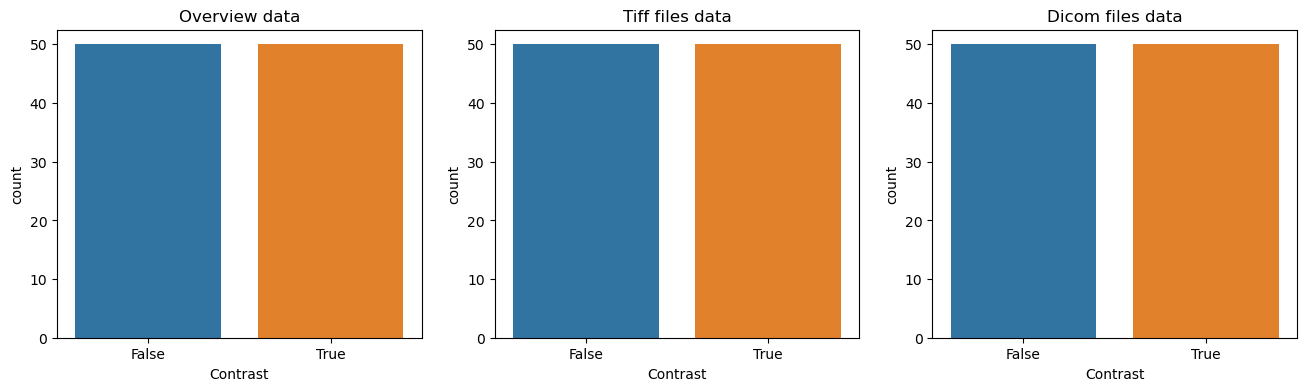

In [55]:
countplot_comparison("Contrast")

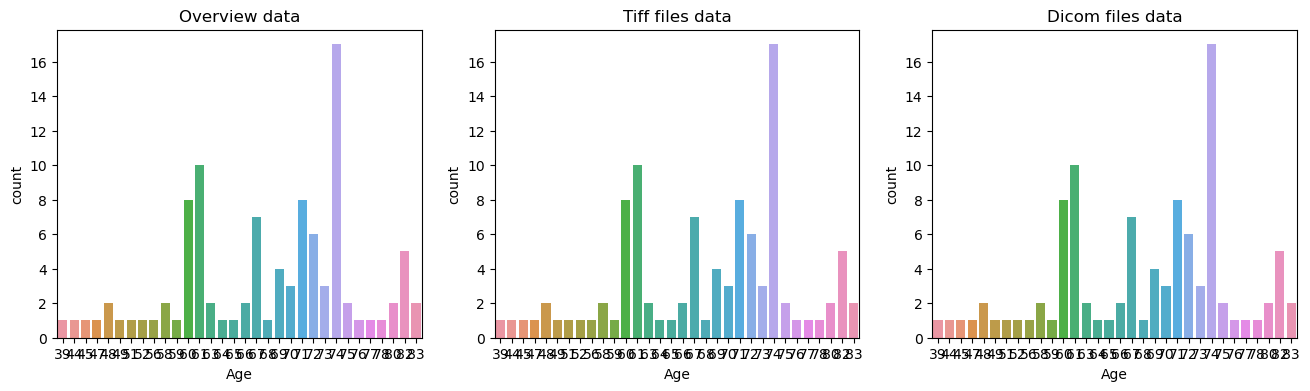

In [54]:
countplot_comparison('Age')

TIFF 이미지와 DICOM 이미지를 모두 나타내는 일반 함수를 정의

grayscale을 사용

In [60]:
def show_images(data, dim = 16, imtype = 'TIFF'):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4, 4, figsize=(16, 20))
    for i, data_row in enumerate(img_data):
        if(imtype=='TIFF'):
            data_row_img = imread(data_row['path'])
        elif(imtype=='DICOM'):
            data_row_img = dicom.read_file(data_row['path'])
        if(imtype=='TIFF'):
            ax[i//4, i%4].matshow(data_row_img,cmap='gray')
        elif(imtype=='DICOM'):
            ax[i//4, i%4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title('Modality: {Modality}, Age: {Age},\nSlice: {ID}, Contrast: {Contrast}'.format(**data_row))
        
    plt.show()

TIFF Images

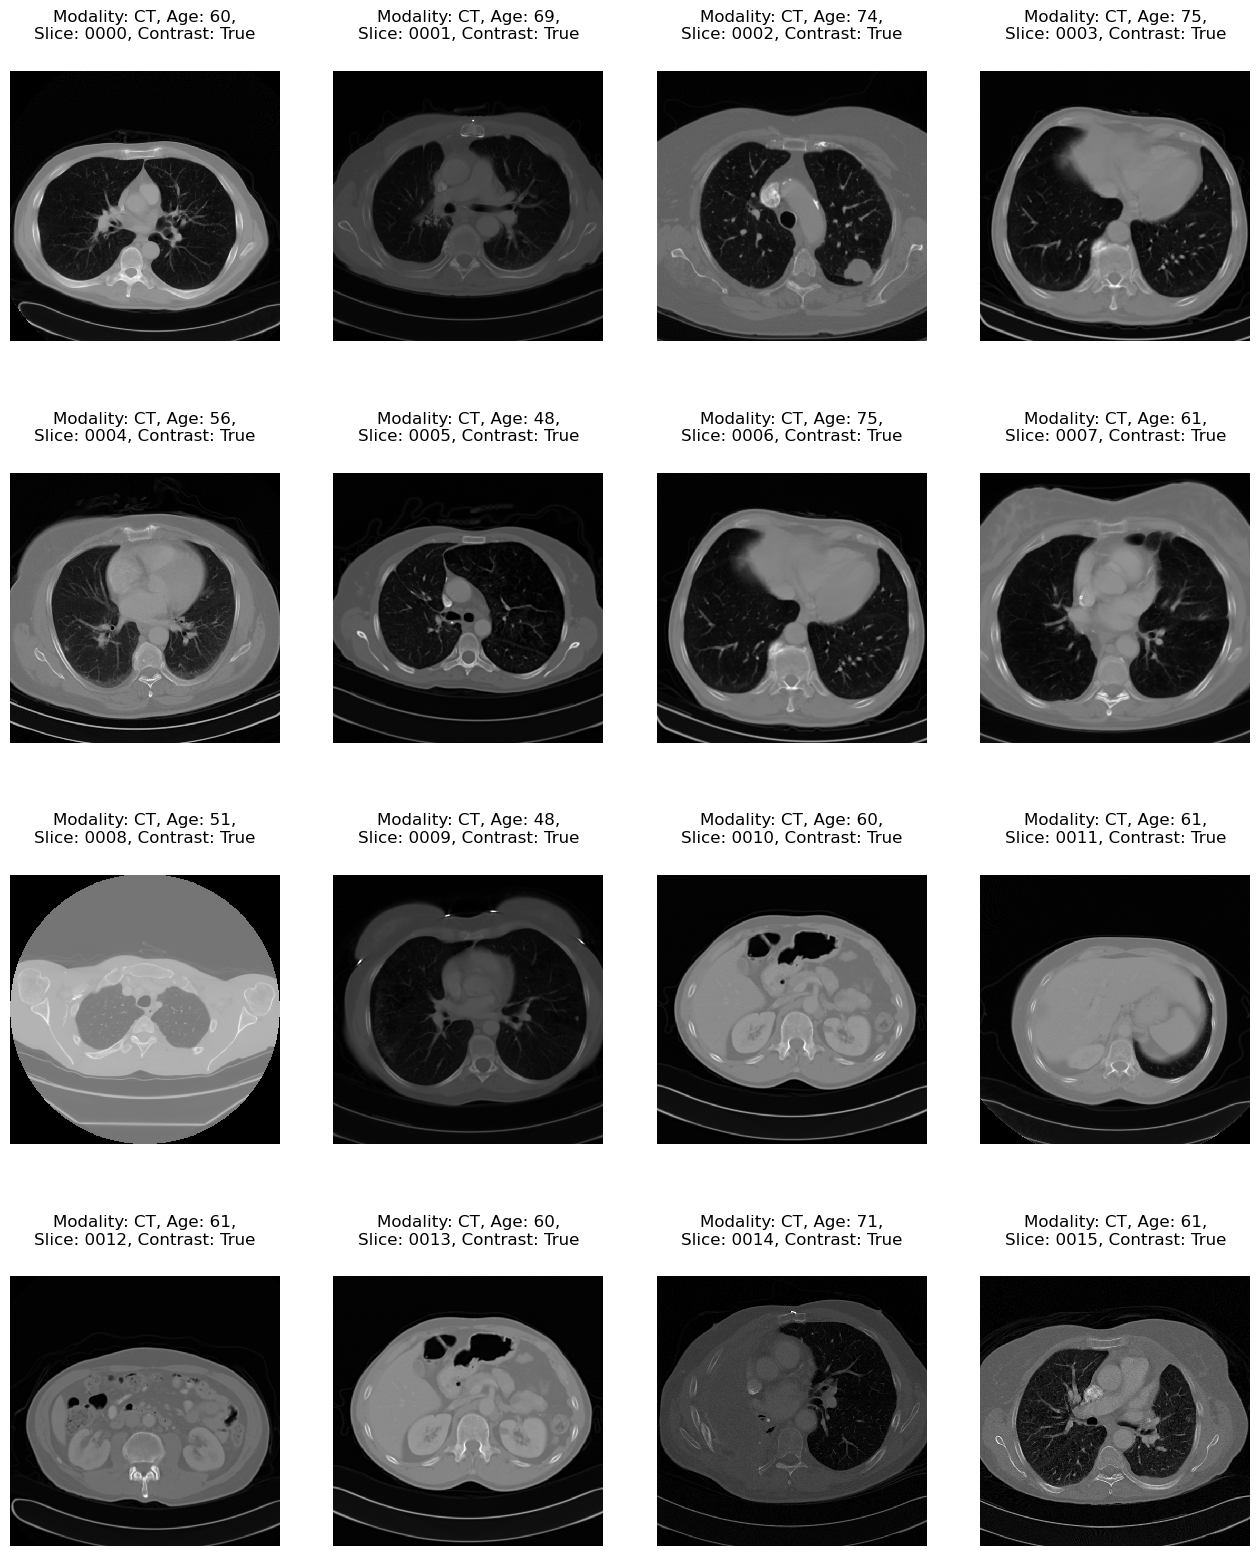

In [61]:
show_images(tiff_data, 16, 'TIFF')

DICOM images

grayscale 사용.

만약 DICOM 이미지들이 하나의 검사에서 나온 일련의 슬라이스(층)들이라면, extract_voxel_data 같은 함수를 사용해 이 슬라이스들을 하나의 3D 복셀(voxel) 텐서로 결합. 복설은 3차원 이미지 필셀을 의미한다. 

 DICOM 2D 이미지들의 부분 집합을 사용하여 3D 장면을 생성하는 방법을 설명하는 코드. 이는 2D DICOM 이미지들을 스택(stack)처럼 쌓아서 3D 이미지를 구성하는 것과 관련

In [64]:
import dicom_numpy

# extract voxel data
def extract_voxel_data(list_of_dicom_files):
    datasets = [dicom.read_file(f) for f in list_of_dicom_files]
    try:
        voxel_ndarray, ijk_to_xyz = dicom_numpy.combine_slices(datasets)
    except dicom_numpy.DicomImportException as e:  
        raise  
    return voxel_ndarray  

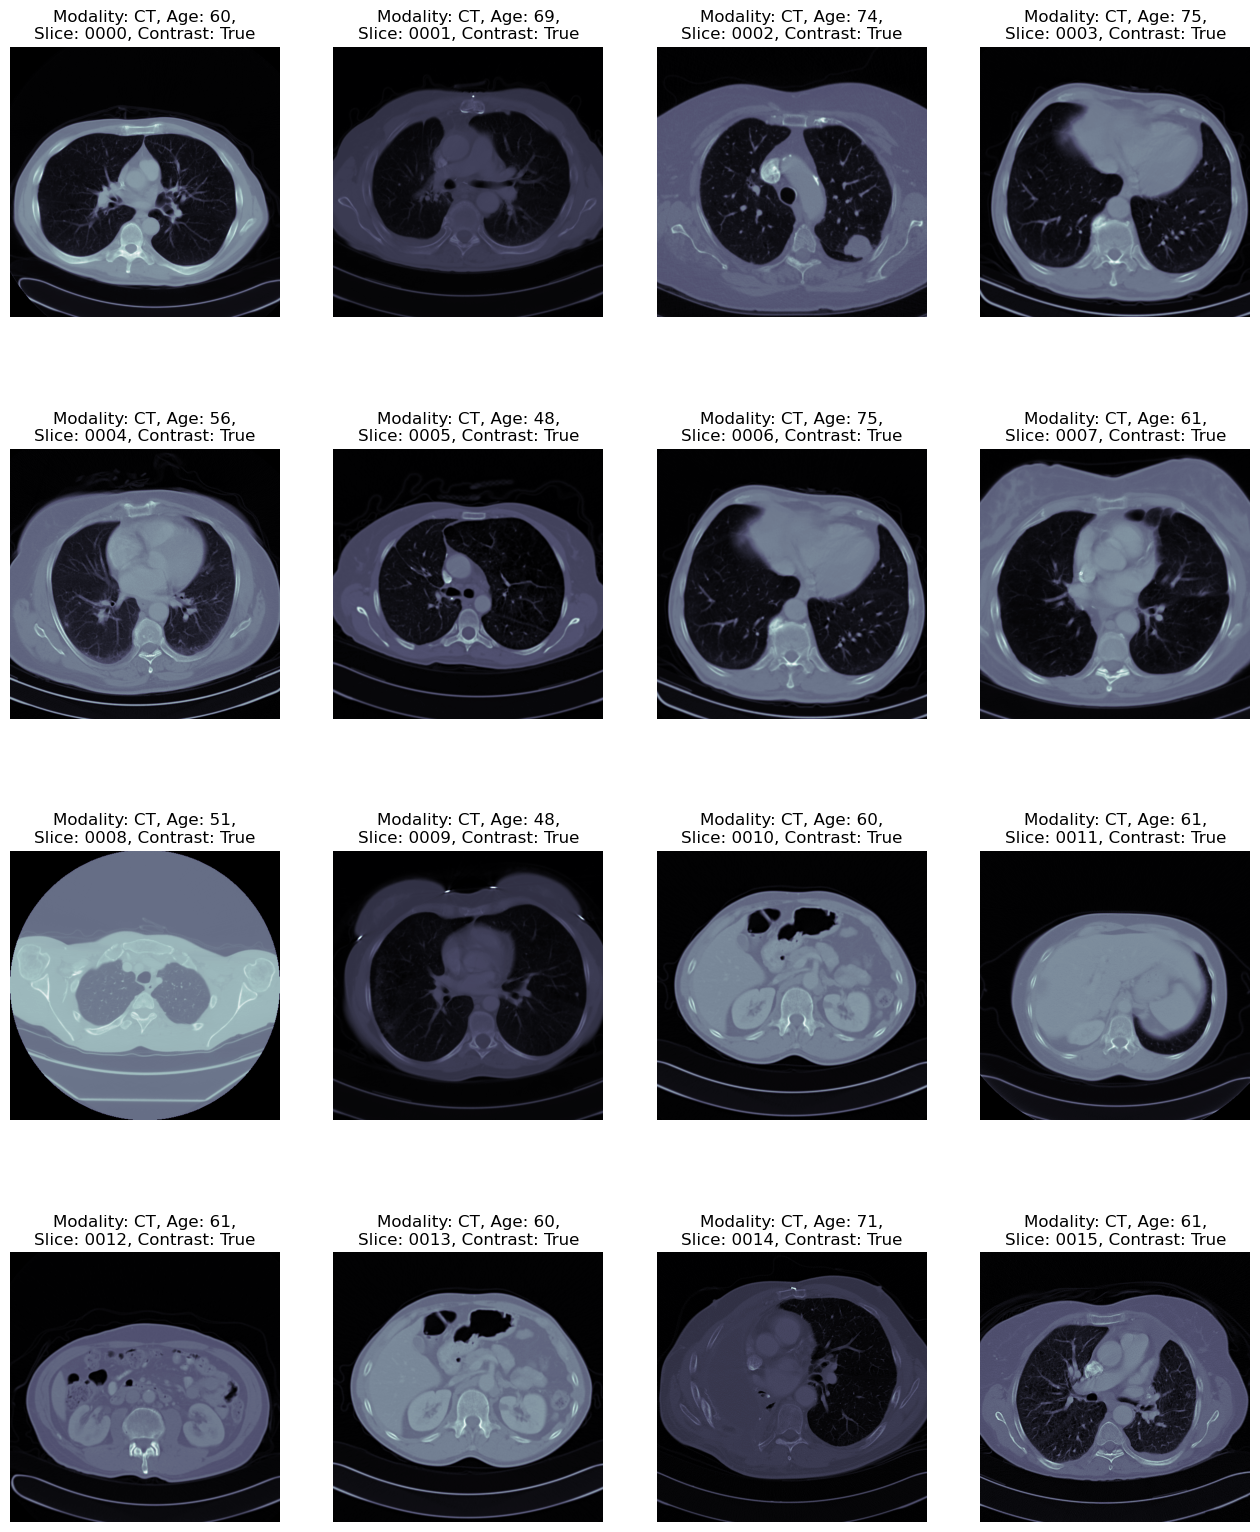

In [65]:
show_images(dicom_data,16,'DICOM')

### More about DICOM data

DICOM file은 훨씬 많은 정보를 갖고있음. 

아래 하나의 DICOM 파일을 보자.

In [66]:
dicom_file_path = list(dicom_data[:1].T.to_dict().values())[0]['path']
dicom_file_dataset = dicom.read_file(dicom_file_path)
dicom_file_dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        VR.UL: 430
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1

DICOM fileDataset에서 많은 다양한 정보를 얻을 수 있음. 예를들어
- Modality
- Manufacturer
- Patient Age
- Patient Sex
- Patient Name
- Patient ID

In [67]:
print("Modality: {}\nManufacturer: {}\nPatient Age: {}\nPatient Sex: {}\nPatient Name: {}\nPatient ID: {}".format(
    dicom_file_dataset.Modality, 
    dicom_file_dataset.Manufacturer,
    dicom_file_dataset.PatientAge,
    dicom_file_dataset.PatientSex,
    dicom_file_dataset.PatientName,
    dicom_file_dataset.PatientID))

Modality: CT
Manufacturer: SIEMENS
Patient Age: 060Y
Patient Sex: M
Patient Name: TCGA-17-Z034
Patient ID: TCGA-17-Z034
